## Result 3: transcript neighborhood



In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

import importlib
import utils
import plot

importlib.reload(utils)
importlib.reload(plot)

from utils import load_merfish_signal_df, load_banksy_result, load_merfish_data, load_boundaries_data
from plot import plot_VSI_map, plot_VSI_region, plot_celltypes, plot_vsi_with_named_squares, plot_circular_neighborhood, plot_knn_neighborhood
from plot import CM, SAVE_FIG

from IPython.display import display
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

In [2]:
fig_path = Path("../data/results/R3")

### Data

#### Signals in the Tissue Section

In [3]:
MERFISH_data_folder_path = Path("../data/mouse_hypothalamus/MERFISH/")

In [4]:
signal_coordinate_df, coordinate_x_m, coordinate_y_m = load_merfish_signal_df(MERFISH_data_folder_path/"merfish_barcodes_example.csv")

In [5]:
top20 = signal_coordinate_df['gene'].value_counts()[:20]

#### Results of Ovrlpy

results:  
- signal integrity  
- signal strength  

In [6]:
ovrlpy_result_folder = Path("../data/results/VSI")

In [7]:
signal_integrity = np.loadtxt(ovrlpy_result_folder/"SignalIntegrity.txt")
signal_strength = np.loadtxt(ovrlpy_result_folder/"SignalStrength.txt")

#### Results of BANKSY

In [8]:
banksy_folder_path = Path("../data/banksy_results/")

In [9]:
banksy_result = load_banksy_result(banksy_folder_path/"banksy_cluster.txt", coordinate_x_m, coordinate_y_m)

#### Segmentation Dataset

In [10]:
merfish_data = load_merfish_data(MERFISH_data_folder_path / "merfish_all_cells.csv", 
                                 banksy_result, coordinate_x_m, coordinate_y_m, 
                                 animal_id=1, bregma_value=-0.24)

#### Cell boundaries

In [11]:
boundaries_df = load_boundaries_data(MERFISH_data_folder_path/'cellboundaries_example_animal.csv', 
                                     merfish_data, coordinate_x_m, coordinate_y_m)

#### OD cell boundaries

In [12]:
# boundaries, MOD
MOD_boundaries = boundaries_df[(boundaries_df['banksy'] == 8) | (boundaries_df['banksy'] == 7)]
other_boundaries = boundaries_df[~boundaries_df['banksy'].isin([8, 7])]

#### Marker Genes

differentially expressed genes identified by BANKSY

In [13]:
# all differentially expressed genes
DE_genes = ['Mlc1', 'Dgkk', 'Cbln2', 'Syt4', 'Gad1', 'Plin3', 'Gnrh1', 'Sln', 'Gjc3', 'Mbp', 'Lpar1', 'Trh', 'Ucn3', 'Cck']
# DE_genes_gm
DE_genes_gm = ['Mlc1', 'Dgkk', 'Cbln2', 'Syt4', 'Gad1', 'Plin3', 'Gnrh1', 'Sln', 'Gjc3']
# DE_genes_wm
DE_genes_wm = ['Mbp', 'Lpar1', 'Trh', 'Ucn3', 'Cck']

### Regions of Interest

cell types and vsi

x_range=[250, 350], y_range=[1450, 1550]  
x_range=[1350, 1450], y_range=[1300, 1400]  
x_range=[850, 950], y_range=[950, 1050]  
x_range=[200, 300], y_range=[300, 400]  
x_range=[1580, 1680], y_range=[350, 450] 

#### VSI

In [14]:
regions = [
    {"x": 250, "y": 1450, "name": "R1"},
    {"x": 1350, "y": 1300, "name": "R2"},
    {"x": 850, "y": 950, "name": "R3"},
    {"x": 200, "y": 300, "name": "R4"},
    {"x": 1580, "y": 350, "name": "R5"}
]

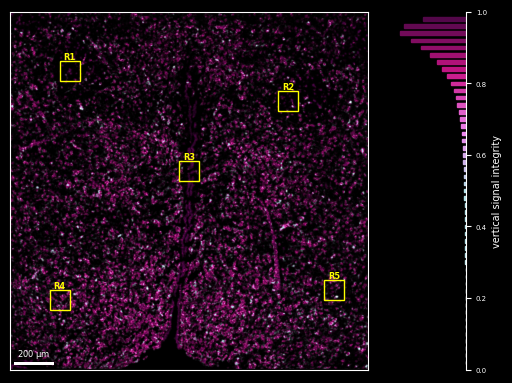

In [15]:
# complete vsi map
VSI_ROI = plot_vsi_with_named_squares(signal_integrity, signal_strength, 
                                      signal_threshold=3.0,
                                      figure_height=10*CM,
                                      cmap="BIH",
                                      side_display='hist',
                                      named_squares=regions,
                                      plot_rasterized=True)
VSI_ROI.savefig(fig_path/"VSI_r5.pdf", **SAVE_FIG)
display(VSI_ROI)

#### region 1
x_range=[250, 350], y_range=[1450, 1550]  

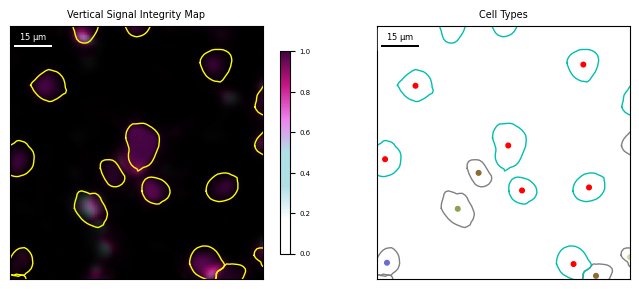

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(18*CM, 8*CM), sharey=True)

plot_VSI_region(integrity=signal_integrity, strength=signal_strength,
             plot_boundary=True, boundary_df=boundaries_df, boundary_width=1,
             side_display='colorbar', signal_threshold=3.0, figure_height=8*CM,
             x_range=[250,350], y_range=[1450, 1550],
             title="Vertical Signal Integrity Map",
             scale_loc='upper left', ax=ax[0])
plot_celltypes(cell_type=banksy_result,
               boundary_df=other_boundaries, MOD_boundary=MOD_boundaries,
               x_range=[250,350], y_range=[1450, 1550],
               title="Cell Types", scale_loc='upper left', ax=ax[1])

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(fig_path/"R1VC.pdf", **SAVE_FIG)
plt.show()

#### region 2
x_range=[1350, 1450], y_range=[1300, 1400]  

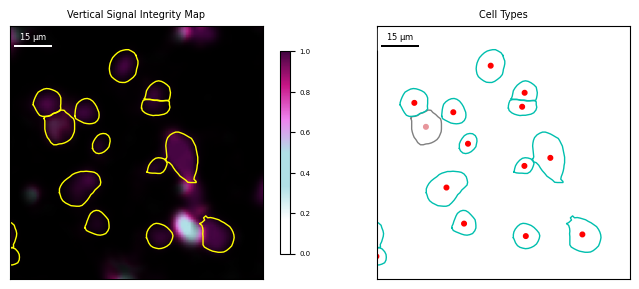

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(18*CM, 8*CM), sharey=True)

plot_VSI_region(integrity=signal_integrity, strength=signal_strength,
             plot_boundary=True, boundary_df=boundaries_df, boundary_width=1,
             side_display='colorbar', signal_threshold=3.0, figure_height=8*CM,
             x_range=[1350, 1450], y_range=[1300, 1400],
             title="Vertical Signal Integrity Map",
             scale_loc='upper left', ax=ax[0])
plot_celltypes(cell_type=banksy_result,
               boundary_df=other_boundaries, MOD_boundary=MOD_boundaries,
               x_range=[1350, 1450], y_range=[1300, 1400],
               title="Cell Types", scale_loc='upper left', ax=ax[1])

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(fig_path/"R2VC.pdf", **SAVE_FIG)
plt.show()

#### region 3
x_range=[850, 950], y_range=[950, 1050]  

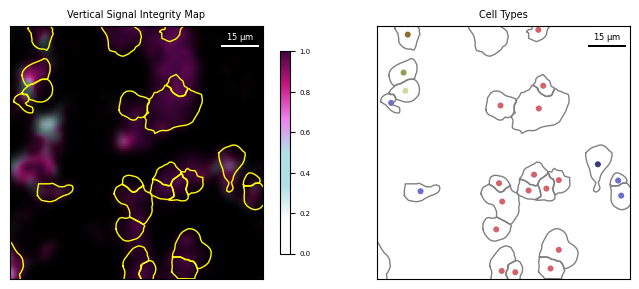

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(18*CM, 8*CM), sharey=True)

plot_VSI_region(integrity=signal_integrity, strength=signal_strength,
             plot_boundary=True, boundary_df=boundaries_df, boundary_width=1,
             side_display='colorbar', signal_threshold=3.0, figure_height=8*CM,
             x_range=[850, 950], y_range=[950, 1050],
             title="Vertical Signal Integrity Map",
             scale_loc='upper right', ax=ax[0])
plot_celltypes(cell_type=banksy_result,
               boundary_df=other_boundaries, MOD_boundary=MOD_boundaries,
               x_range=[850, 950], y_range=[950, 1050],
               title="Cell Types", scale_loc='upper right', ax=ax[1])

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(fig_path/"R3VC.pdf", **SAVE_FIG)
plt.show()

#### region 4
x_range=[200, 300], y_range=[300, 400]  

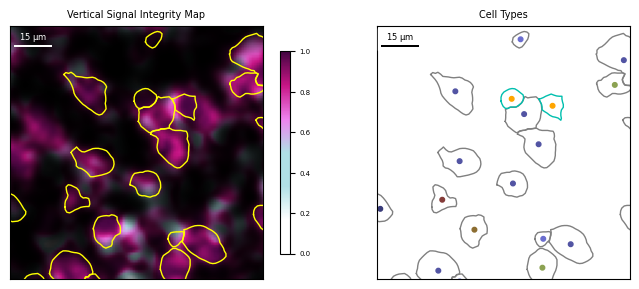

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(18*CM, 8*CM), sharey=True)

plot_VSI_region(integrity=signal_integrity, strength=signal_strength,
             plot_boundary=True, boundary_df=boundaries_df, boundary_width=1,
             side_display='colorbar', signal_threshold=3.0, figure_height=8*CM,
             x_range=[200, 300], y_range=[300, 400],
             title="Vertical Signal Integrity Map",
             scale_loc='upper left', ax=ax[0])
plot_celltypes(cell_type=banksy_result,
               boundary_df=other_boundaries, MOD_boundary=MOD_boundaries,
               x_range=[200, 300], y_range=[300, 400],
               title="Cell Types", scale_loc='upper left', ax=ax[1])

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(fig_path/"R4VC.pdf", **SAVE_FIG)
plt.show()

#### region 5
x_range=[1580, 1680], y_range=[350,450]  

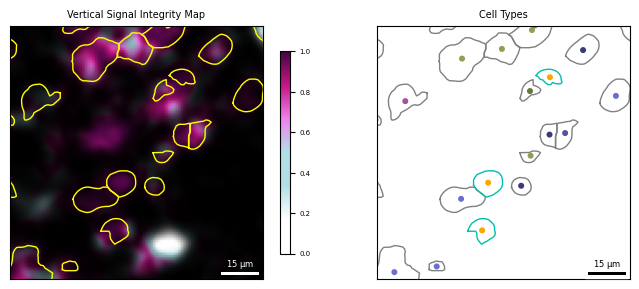

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(18*CM, 8*CM), sharey=True)

plot_VSI_region(integrity=signal_integrity, strength=signal_strength,
             plot_boundary=True, boundary_df=boundaries_df, boundary_width=1,
             side_display='colorbar', signal_threshold=3.0, figure_height=8*CM,
             x_range=[1580, 1680], y_range=[350,450],
             title="Vertical Signal Integrity Map",
             scale_loc='lower right', ax=ax[0])
plot_celltypes(cell_type=banksy_result,
               boundary_df=other_boundaries, MOD_boundary=MOD_boundaries,
               x_range=[1580, 1680], y_range=[350,450],
               title="Cell Types", scale_loc='lower right', ax=ax[1])

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(fig_path/"R5VC.pdf", **SAVE_FIG)
plt.show()

#### for thesis layout

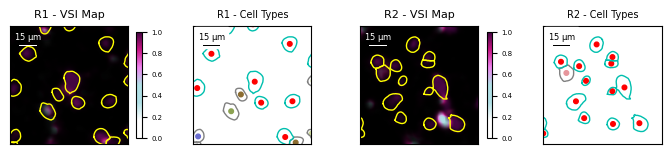

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(18*CM, 4*CM), width_ratios=[1.1,0.9,1.1,0.9])

plot_VSI_region(integrity=signal_integrity, strength=signal_strength,
             plot_boundary=True, boundary_df=boundaries_df, boundary_width=1,
             side_display='colorbar', signal_threshold=3.0, figure_height=8*CM,
             x_range=[250,350], y_range=[1450, 1550],
             title="R1 - VSI Map",
             scale_loc='upper left', ax=ax[0])
plot_celltypes(cell_type=banksy_result,
               boundary_df=other_boundaries, MOD_boundary=MOD_boundaries,
               x_range=[250,350], y_range=[1450, 1550],
               title="R1 - Cell Types", scale_loc='upper left', ax=ax[1])

plot_VSI_region(integrity=signal_integrity, strength=signal_strength,
             plot_boundary=True, boundary_df=boundaries_df, boundary_width=1,
             side_display='colorbar', signal_threshold=3.0, figure_height=8*CM,
             x_range=[1350, 1450], y_range=[1300, 1400],
             title="R2 - VSI Map",
             scale_loc='upper left', ax=ax[2])
plot_celltypes(cell_type=banksy_result,
               boundary_df=other_boundaries, MOD_boundary=MOD_boundaries,
               x_range=[1350, 1450], y_range=[1300, 1400],
               title="R2 - Cell Types", scale_loc='upper left', ax=ax[3])

plt.tight_layout()
plt.savefig(fig_path/"ROIVC1.pdf", **SAVE_FIG)
plt.show()

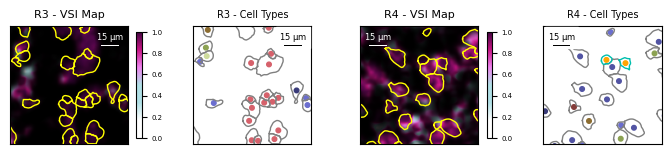

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(18*CM, 4*CM), width_ratios=[1.1,0.9,1.1,0.9])

plot_VSI_region(integrity=signal_integrity, strength=signal_strength,
             plot_boundary=True, boundary_df=boundaries_df, boundary_width=1,
             side_display='colorbar', signal_threshold=3.0, figure_height=8*CM,
             x_range=[850, 950], y_range=[950, 1050],
             title="R3 - VSI Map",
             scale_loc='upper right', ax=ax[0])
plot_celltypes(cell_type=banksy_result,
               boundary_df=other_boundaries, MOD_boundary=MOD_boundaries,
               x_range=[850, 950], y_range=[950, 1050],
               title="R3 - Cell Types", scale_loc='upper right', ax=ax[1])

plot_VSI_region(integrity=signal_integrity, strength=signal_strength,
             plot_boundary=True, boundary_df=boundaries_df, boundary_width=1,
             side_display='colorbar', signal_threshold=3.0, figure_height=8*CM,
             x_range=[200, 300], y_range=[300, 400],
             title="R4 - VSI Map",
             scale_loc='upper left', ax=ax[2])
plot_celltypes(cell_type=banksy_result,
               boundary_df=other_boundaries, MOD_boundary=MOD_boundaries,
               x_range=[200, 300], y_range=[300, 400],
               title="R4 - Cell Types", scale_loc='upper left', ax=ax[3])

plt.tight_layout()
plt.savefig(fig_path/"ROIVC2.pdf", **SAVE_FIG)
plt.show()

C:\Users\tomo\AppData\Local\Temp\ipykernel_5516\1616967460.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20b', len(unique_other_labels))


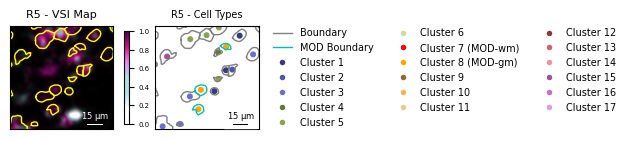

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18*CM, 4*CM))

plot_VSI_region(integrity=signal_integrity, strength=signal_strength,
             plot_boundary=True, boundary_df=boundaries_df, boundary_width=1,
             side_display='colorbar', signal_threshold=3.0, figure_height=8*CM,
             x_range=[1580, 1680], y_range=[350,450],
             title="R5 - VSI Map",
             scale_loc='lower right', ax=ax[0])
plot_celltypes(cell_type=banksy_result,
               boundary_df=other_boundaries, MOD_boundary=MOD_boundaries,
               x_range=[1580, 1680], y_range=[350,450],
               title="R5 - Cell Types", scale_loc='lower right', ax=ax[1])

from matplotlib.lines import Line2D

all_labels = banksy_result['banksy_cluster'].unique()
color_map = {7: 'red', 8: 'orange'}
unique_other_labels = [label for label in all_labels if label not in color_map]
colormap = plt.cm.get_cmap('tab20b', len(unique_other_labels))
other_colors = {
    label: colormap(i) for i, label in enumerate(sorted(unique_other_labels))
}
cmap = {**color_map, **other_colors}

legend_elements = [
    Line2D([0], [0], color='grey', lw=1, label='Boundary'),
    Line2D([0], [0], color='#00bfae', lw=1, label='MOD Boundary')
]

def format_label(label):
    if label == 7:
        return "Cluster 7 (MOD-wm)"
    elif label == 8:
        return "Cluster 8 (MOD-gm)"
    else:
        return f"Cluster {label}"

legend_elements += [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=cmap[label], markeredgecolor=None,
           markersize=5, label=format_label(label))
    for label in sorted(all_labels)
]

ax[1].legend(
    handles=legend_elements,
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    ncol=3,
    fontsize=7,
    frameon=False
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(fig_path/"ROIVC3.pdf", **SAVE_FIG)
plt.show()

### Circle and kNN

#### region1

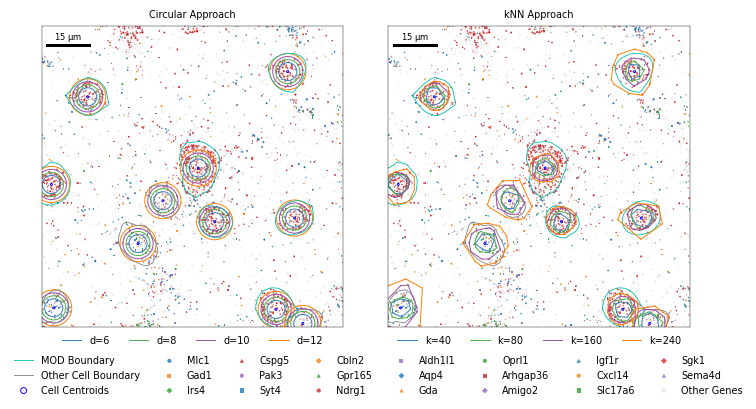

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(18*CM, 11*CM), sharey=True)

handles = plot_circular_neighborhood(signals_df=signal_coordinate_df,
                            centroid_df=merfish_data, 
                            MOD_boundaries=MOD_boundaries,
                            boundaries_df=other_boundaries, 
                            x_range=[250, 350], y_range=[1450, 1550], 
                            diameters=[6, 8, 10, 12], true_boundary=True, 
                            plot_top20=True, top20=top20.index, ax=ax[0], scale_loc = "upper left")
handles = plot_knn_neighborhood(signals_df=signal_coordinate_df,
                                centroid_df=merfish_data, 
                                MOD_boundaries=MOD_boundaries,
                                boundaries_df=other_boundaries, 
                                x_range=[250, 350], y_range=[1450, 1550], 
                                neighbors=[40, 80, 160, 240], true_boundary=True, 
                                plot_top20=True, top20=top20.index, ax=ax[1], scale_loc = "upper left")

fig.legend(
    [h for h, _ in handles],
    [l for _, l in handles],
    loc='lower center', bbox_to_anchor=(0.51, 0),
    ncol=8, fontsize=7, frameon=False, markerscale=3
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(fig_path/"R1.pdf", **SAVE_FIG)
plt.show()

#### region2

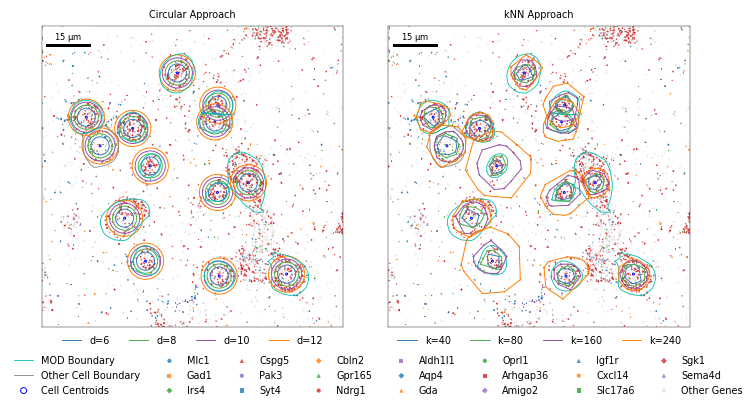

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(18*CM, 11*CM), sharey=True)

handles = plot_circular_neighborhood(signals_df=signal_coordinate_df,
                            centroid_df=merfish_data, 
                            MOD_boundaries=MOD_boundaries,
                            boundaries_df=other_boundaries, 
                            x_range=[1350, 1450], y_range=[1300, 1400],  
                            diameters=[6, 8, 10, 12], true_boundary=True, 
                            plot_top20=True, top20=top20.index, ax=ax[0], scale_loc = "upper left")
handles = plot_knn_neighborhood(signals_df=signal_coordinate_df,
                                centroid_df=merfish_data, 
                                MOD_boundaries=MOD_boundaries,
                                boundaries_df=other_boundaries, 
                                x_range=[1350, 1450], y_range=[1300, 1400],  
                                neighbors=[40, 80, 160, 240], true_boundary=True, 
                                plot_top20=True, top20=top20.index, ax=ax[1], scale_loc = "upper left")
fig.legend(
    [h for h, _ in handles],
    [l for _, l in handles],
    loc='lower center', bbox_to_anchor=(0.51, 0),
    ncol=8, fontsize=7, frameon=False, markerscale=3
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(fig_path/"R2.pdf", **SAVE_FIG)
plt.show()

#### region3

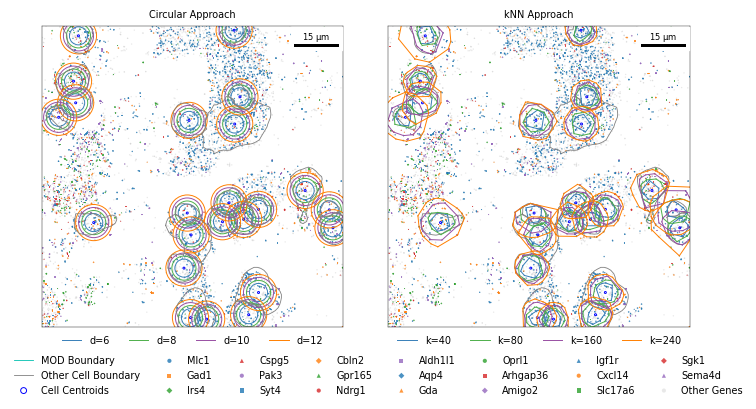

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(18*CM, 11*CM), sharey=True)

handles = plot_circular_neighborhood(signals_df=signal_coordinate_df,
                            centroid_df=merfish_data, 
                            MOD_boundaries=MOD_boundaries,
                            boundaries_df=other_boundaries, 
                            x_range=[850, 950], y_range=[950, 1050],
                            diameters=[6, 8, 10, 12], true_boundary=True, 
                            plot_top20=True, top20=top20.index, ax=ax[0], scale_loc = "upper right")
handles = plot_knn_neighborhood(signals_df=signal_coordinate_df,
                                centroid_df=merfish_data, 
                                MOD_boundaries=MOD_boundaries,
                                boundaries_df=other_boundaries, 
                                x_range=[850, 950], y_range=[950, 1050], 
                                neighbors=[40, 80, 160, 240], true_boundary=True, 
                                plot_top20=True, top20=top20.index, ax=ax[1], scale_loc = "upper right")
fig.legend(
    [h for h, _ in handles],
    [l for _, l in handles],
    loc='lower center', bbox_to_anchor=(0.51, 0),
    ncol=8, fontsize=7, frameon=False, markerscale=3
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(fig_path/"R3.pdf", **SAVE_FIG)
plt.show()

#### region4

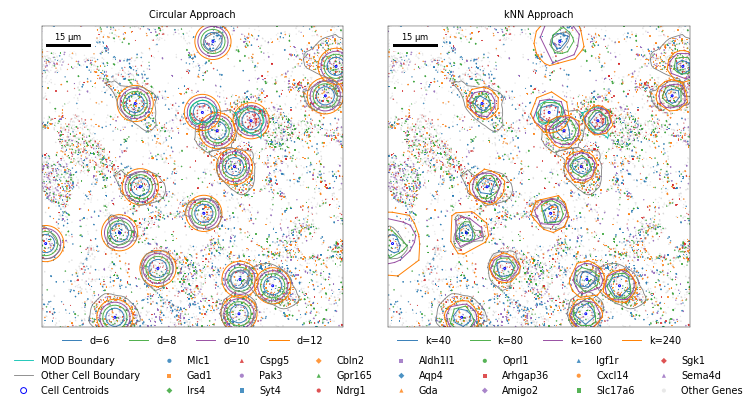

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(18*CM, 11*CM), sharey=True)

handles = plot_circular_neighborhood(signals_df=signal_coordinate_df,
                            centroid_df=merfish_data, 
                            MOD_boundaries=MOD_boundaries,
                            boundaries_df=other_boundaries, 
                            x_range=[200, 300], y_range=[300, 400],
                            diameters=[6, 8, 10, 12], true_boundary=True, 
                            plot_top20=True, top20=top20.index, ax=ax[0], scale_loc = "upper left")
handles = plot_knn_neighborhood(signals_df=signal_coordinate_df,
                                centroid_df=merfish_data, 
                                MOD_boundaries=MOD_boundaries,
                                boundaries_df=other_boundaries, 
                                x_range=[200, 300], y_range=[300, 400],
                                neighbors=[40, 80, 160, 240], true_boundary=True, 
                                plot_top20=True, top20=top20.index, ax=ax[1], scale_loc = "upper left")
fig.legend(
    [h for h, _ in handles],
    [l for _, l in handles],
    loc='lower center', bbox_to_anchor=(0.51, 0),
    ncol=8, fontsize=7, frameon=False, markerscale=3
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(fig_path/"R4.pdf", **SAVE_FIG)
plt.show()

#### region5

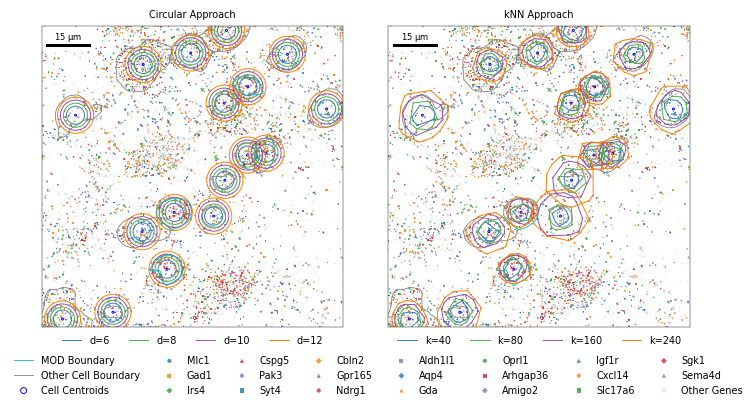

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(18*CM, 11*CM), sharey=True)

handles = plot_circular_neighborhood(signals_df=signal_coordinate_df,
                            centroid_df=merfish_data, 
                            MOD_boundaries=MOD_boundaries,
                            boundaries_df=other_boundaries, 
                            x_range=[1580, 1680], y_range=[350,450],
                            diameters=[6, 8, 10, 12], true_boundary=True, 
                            plot_top20=True, top20=top20.index, ax=ax[0], scale_loc = "upper left")
handles = plot_knn_neighborhood(signals_df=signal_coordinate_df,
                                centroid_df=merfish_data, 
                                MOD_boundaries=MOD_boundaries,
                                boundaries_df=other_boundaries, 
                                x_range=[1580, 1680], y_range=[350,450],
                                neighbors=[40, 80, 160, 240], true_boundary=True, 
                                plot_top20=True, top20=top20.index, ax=ax[1], scale_loc = "upper left")
fig.legend(
    [h for h, _ in handles],
    [l for _, l in handles],
    loc='lower center', bbox_to_anchor=(0.51, 0),
    ncol=8, fontsize=7, frameon=False, markerscale=3
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(fig_path/"R5.pdf", **SAVE_FIG)
plt.show()